In [1]:
# Define density functions for BBV calculation
def smow_dens(T):
  # Function to calculate density of standard mean ocean water based on matlab function

  #Define constants:
  a0 = 999.842594
  a1 = 6.793952e-2
  a2 = -9.095290e-3
  a3 = 1.001685e-4
  a4 = -1.120083e-6
  a5 = 6.536332e-9

  T68 = T * 1.00024
  dens = a0 + (a1 + (a2 + (a3 + (a4 + a5 * T68) * T68) * T68) * T68) * T68
  return dens

def sw_dens(S, T):
  # Function to calculate density of sea water based on matlab function

  # Inputs:
  #   S = salinity (PSU)
  #   T = temperature (deg C)

  # Output:
  # density (kg/m^3) of salt water with properties S,T,P=0

  # Define constants
  T68 = T * 1.00024
  b0 = 8.24493e-1
  b1 = -4.0899e-3
  b2 = 7.6438e-5
  b3 = -8.2467e-7
  b4 = 5.3875e-9
  c0 = -5.72466e-3
  c1 = 1.0227e-4
  c2 = -1.6546e-6
  d0 = 4.8314e-4

  dens = smow_dens(T) + (b0 + b1*T68 + b2*T68**2 + b3*T68**3 + b4*T68**4) * S + (c0 + c1*T68 + c2*T68**2) * S**1.5 + d0*S**2

  return dens

In [2]:
import numpy as np
import gsw

def teos10_sigma0(S,T,Z,X,Y):
    """ 
    The function is for calculating the potential density of reference pressure 
    of 0 dbar based on the TEOS-10

    The function is using the GSW-Python module. The module is designed 
    to follow the new standard from http://www.teos-10.org/ . 

    Modules used:
    - gsw (https://teos-10.github.io/GSW-Python/intro.html)

    Functions used:
    - gsw.p_from_z : calculate pressure using depth
    - gsw.SA_from_SP : calculate absolute salinity from pratical salinity
    - gsw.CT_from_pt : calculate conservative temperature from potential temperature
    - gsw.rho : calculate density from conservative temp and absolute salinity

    Parameters
    ----------
    S : float or np.ndarray
        Pratical salinity. The DataArray need to have depth in the unit 
        of meters or dbar for correct calculation.
    T : float or np.ndarray
        Potential temperature with reference level at 0 dbar (sea level). 
        The DataArray need to have depth in the unit of meters or dbar for 
        correct calculation. 
    Z : float or np.ndarray
        Depth. The DataArray need to have depth in the unit 
        of meters or dbar for correct calculation.
    X : float
        Longitude. The single value of longitude in the unit
        of degrees for correct calculation.
    Y : float 
        Latitude. The single value of latitude in the unit
        of degrees for correct calculation.


    Returns
    -------
    sigma0 : np.ndarray
        potential density anomaly with respect to a reference pressure of 0 dbar,
        that is, this potential density - 1000 kg/m^3.

    Raises
    ------

    """

    # assuming 1000 m = 1000 dbar
    # 1 dbar = 10 kPa = 10000 Pa
    # check if depth increase monotonically and is positive
    if not np.all(np.diff(Z) > 0) or np.any(Z < 0):
        raise ValueError("Z must be positive and increase monotonically.")
    
    # calculate pressure using depth
    pressure = gsw.p_from_z(
        -Z, 
        Y,
        geo_strf_dyn_height=0,
        sea_surface_geopotential=0
    )
    
    # calculate absolute salinity from pratical salinity
    abs_sal = gsw.SA_from_SP(S, pressure, X, Y)

    # calculate conservative temperature from potential temperature
    cons_temp = gsw.CT_from_pt(abs_sal, T)

    # calculate in-situ density from conservative temp and absolute salinity
    # rho = gsw.rho(abs_sal, cons_temp, pressure)

    # calculate potential density of reference pressure of 0 dbar from conservative temp and absolute salinity
    # the function output potential density anomaly with respect to a reference pressure of 0 dbar,
    # that is, this potential density - 1000 kg/m^3. Therefore, adding back 1000 for comparison with EOS80
    sigma0 = gsw.sigma0(abs_sal, cons_temp)+1000

    return sigma0

In [3]:
from typing import Literal
import numpy as np
from scipy.interpolate import CubicSpline

def column_bbv(
        temp_col: np.ndarray,
        salt_col: np.ndarray,
        depth_col: np.ndarray,
        lon: float,
        lat: float,
        eos_version: Literal['eos-80','teos-10'] = 'eos-80',
        interp_method : Literal['linear', 'cubic'] = 'cubic'):
    """
    Calculates the Brunt-Väisälä frequency (BBV) for a single water column.

    This function is designed to be used with xarray.apply_ufunc.
    """
    # setup constant
    RHO0 = 1027 # Reference density
    G = 9.807   # Gravitational constant

    # Calculate density profile
    if eos_version == 'eos-80':
        dens_col = sw_dens(salt_col, temp_col)
    elif eos_version == 'teos-10':
        # check if lon lat is provided
        if lon is None or lat is None:
            raise ValueError("Longitude and latitude must be provided for TEOS-10 calculations.")
        dens_col = teos10_sigma0(salt_col, temp_col, depth_col, lon, lat)
    else:
        raise ValueError("Unknown equation of state of seawater")

    # check if depth increase monotonically and is positive
    if not np.all(np.diff(depth_col) > 0) or np.any(depth_col < 0):
        raise ValueError("Depth must be positive and increase monotonically.")

    # Remove any NaN values from the input column which would cause interpolation to fail
    valid_indices = ~np.isnan(dens_col)
    dens_col = dens_col[valid_indices]
    depth_col = depth_col[valid_indices]
    
    # Ensure there's enough data to interpolate
    if len(depth_col) < 2:
        return np.nan

    # 1. Interpolate density to a regular 1m grid in the vertical
    # make sure if depth of the column is less than 200 the value
    # below the bottom depth is set to NaN
    new_depth_col = np.arange(0, 201, dtype=depth_col.dtype)
    if interp_method == 'cubic':
        interp_func = CubicSpline(depth_col, dens_col, extrapolate=False)
        new_dens_col = interp_func(new_depth_col)
    elif interp_method == 'linear':
        new_dens_col = np.interp(new_depth_col, depth_col, dens_col, left=np.nan, right=np.nan)
    else:
        raise ValueError("Unknown interpolation method")

    
    # 2. Calculate the vertical density gradient (d(rho)/dz)
    # in this implementation we assume 
    # 1. depth increase downward and positive
    # 2. density increase downward and positive when stable
    # due to ds = z[i+1]-z[i] = 1, we simplify to drho_dz = rho[i+1]-rho[i]
    # where drho_dz > 0 when stable; drho_dz < 0 when unstable
    drho_dz =  new_dens_col[1:] - new_dens_col[:-1]
    
    # 3. Calculate Brunt-Väisälä frequency squared (N^2)
    # The formula is N^2 = (-g / rho0) * (d(rho) / dz)
    # But since density increases with depth, d(rho)/dz is positive, making N^2 negative.
    # here we implicitly deal with this by changing the formula to 
    # N^2 = (g / rho0) * (d(rho) / dz).
    n_squared = (G / RHO0) * drho_dz
    
    # Set unstable points (negative N^2) to 0 before taking the square root
    n_squared[n_squared < 0] = 0
    n = np.sqrt(n_squared)
    
    # 4. Average the frequency over the upper 200m and return
    return np.nanmean(n)

In [4]:
dict_data_info = {
    "region": "northeast_pacific",
    "subdomain": "full_domain",
    "experiment_type": "hindcast",
    "output_frequency": "monthly",
    "grid_type": "raw",
    "release": "r20250509",
    "data_source": "local",
    "local_top_dir": "/Projects/CEFI/regional_mom6/"
}
from mom6.mom6_module.mom6_read import AccessFiles
cefi_data_access = AccessFiles(**dict_data_info)

In [5]:
so_path = cefi_data_access.get(variable='so')[0]
thetao_path = cefi_data_access.get(variable='thetao')[0]
static_path = cefi_data_access.get(variable='ocean_static')[0]


In [6]:
import xarray as xr
da_so = xr.open_dataset(so_path,chunks={'time': 1, 'yh': 50, 'xh': 50, 'z_l': -1})['so'].isel(time=slice(0,12))
da_thetao = xr.open_dataset(thetao_path,chunks={'time': 1, 'yh': 50, 'xh': 50, 'z_l': -1})['thetao'].isel(time=slice(0,12))
da_geolon = xr.open_dataset(static_path,chunks={'yh': 50, 'xh': 50})['geolon']
da_geolat = xr.open_dataset(static_path,chunks={'yh': 50, 'xh': 50})['geolat']

In [7]:
print("--- Calculating Brunt-Väisälä Frequency (BBV) ---")

# Apply the BBV helper function across all dimensions except 'z'
bbv_200 = xr.apply_ufunc(
    column_bbv,
    da_thetao,
    da_so,
    da_thetao['z_l'],
    da_geolon,
    da_geolat,
    kwargs={
        'eos_version': 'teos-10',
        'interp_method': 'cubic'
    },
    input_core_dims=[['z_l'], ['z_l'], ['z_l'], [], []],
    output_core_dims=[[]],
    exclude_dims=set(('z_l',)),
    vectorize=True,
    dask="parallelized",
    output_dtypes=[float]
)

--- Calculating Brunt-Väisälä Frequency (BBV) ---


In [8]:
bbv_200

<xarray.DataArray 'thetao' (time: 12, yh: 816, xh: 342)> Size: 27MB
dask.array<transpose, shape=(12, 816, 342), dtype=float64, chunksize=(1, 50, 50), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 96B 1993-01-16T12:00:00 ... 1993-12-16T12:...
  * xh       (xh) float64 3kB 229.1 229.2 229.3 229.3 ... 254.8 254.9 255.0
  * yh       (yh) float64 7kB 13.86 13.93 14.0 14.07 ... 59.5 59.51 59.52 59.52
Attributes:
    units:          degC
    long_name:      Sea Water Potential Temperature
    cell_methods:   area:mean z_l:mean yh:mean xh:mean time: mean
    cell_measures:  volume: volcello area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_potential_temperature

In [9]:
# more worker less threads due to GIL of the task involved
from dask.distributed import Client
client = Client(n_workers=80, threads_per_worker=1)
print(client.dashboard_link)
da_bbv_200 = bbv_200.compute()

http://127.0.0.1:8787/status


In [10]:
ds_bbv_200 = xr.Dataset()
ds_bbv_200['bbv_200'] = da_bbv_200
ds_bbv_200 = xr.merge([ds_bbv_200, xr.open_dataset(static_path)])
ds_bbv_200 = ds_bbv_200.set_coords(['geolon', 'geolat'])
# due to missing value in the coordinate
ds_bbv_200['geolon'] = ds_bbv_200['geolon'].where(ds_bbv_200['geolon'].notnull(), ds_bbv_200['geolon'].min())
ds_bbv_200['geolat'] = ds_bbv_200['geolat'].where(ds_bbv_200['geolat'].notnull(), ds_bbv_200['geolat'].min())

In [11]:
ds_bbv_200.bbv_200.attrs['units'] = '1/s'
ds_bbv_200.bbv_200.attrs['long_name'] = 'Mean Brunt-Vaisala Frequency in upper 200m'
ds_bbv_200.bbv_200.attrs['standard_name'] = 'mean_brunt_vaisala_frequency_200m'


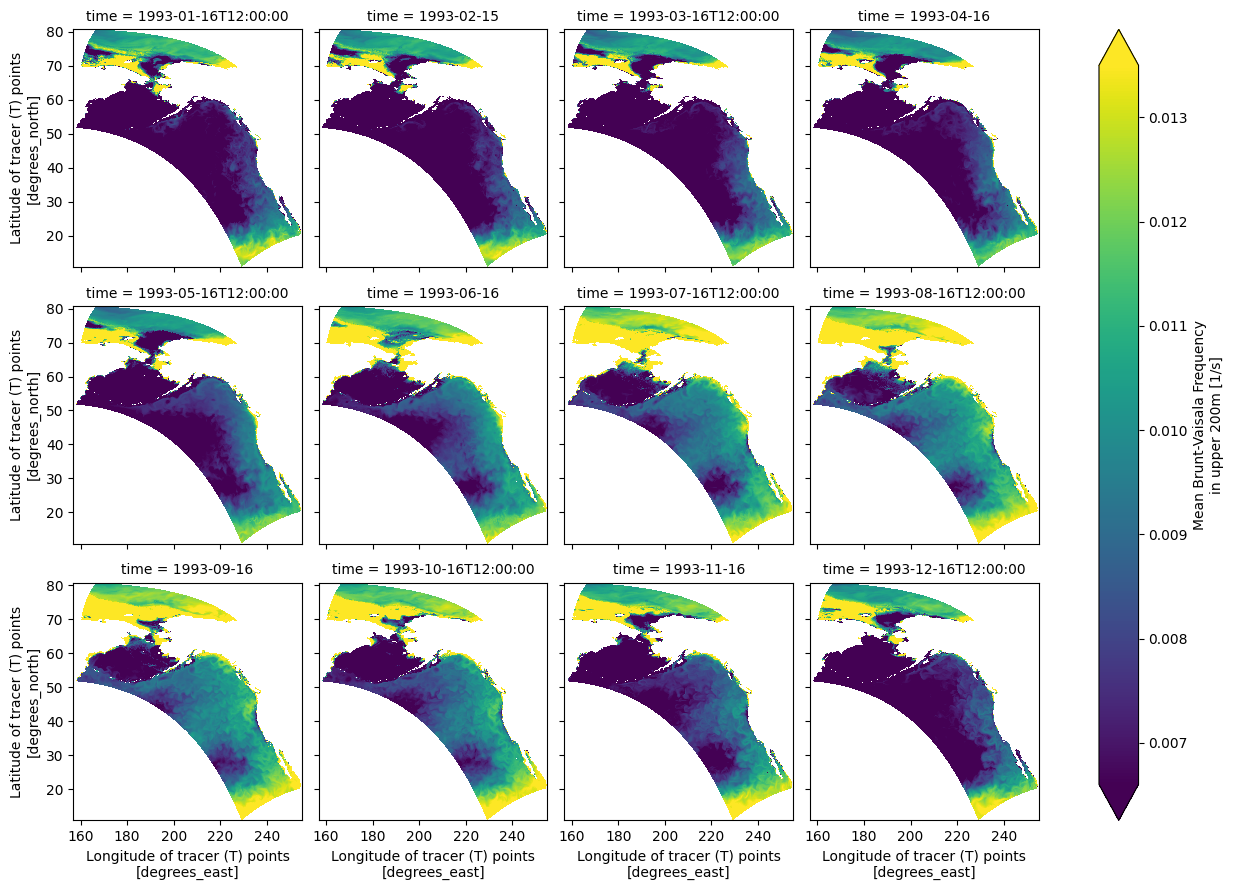

In [12]:
ds_bbv_200['bbv_200'].plot(x='geolon',y='geolat',vmin=0.0066,vmax=0.0135,col='time',col_wrap=4, cmap='viridis')

--- Calculating Brunt-Väisälä Frequency (BBV) ---


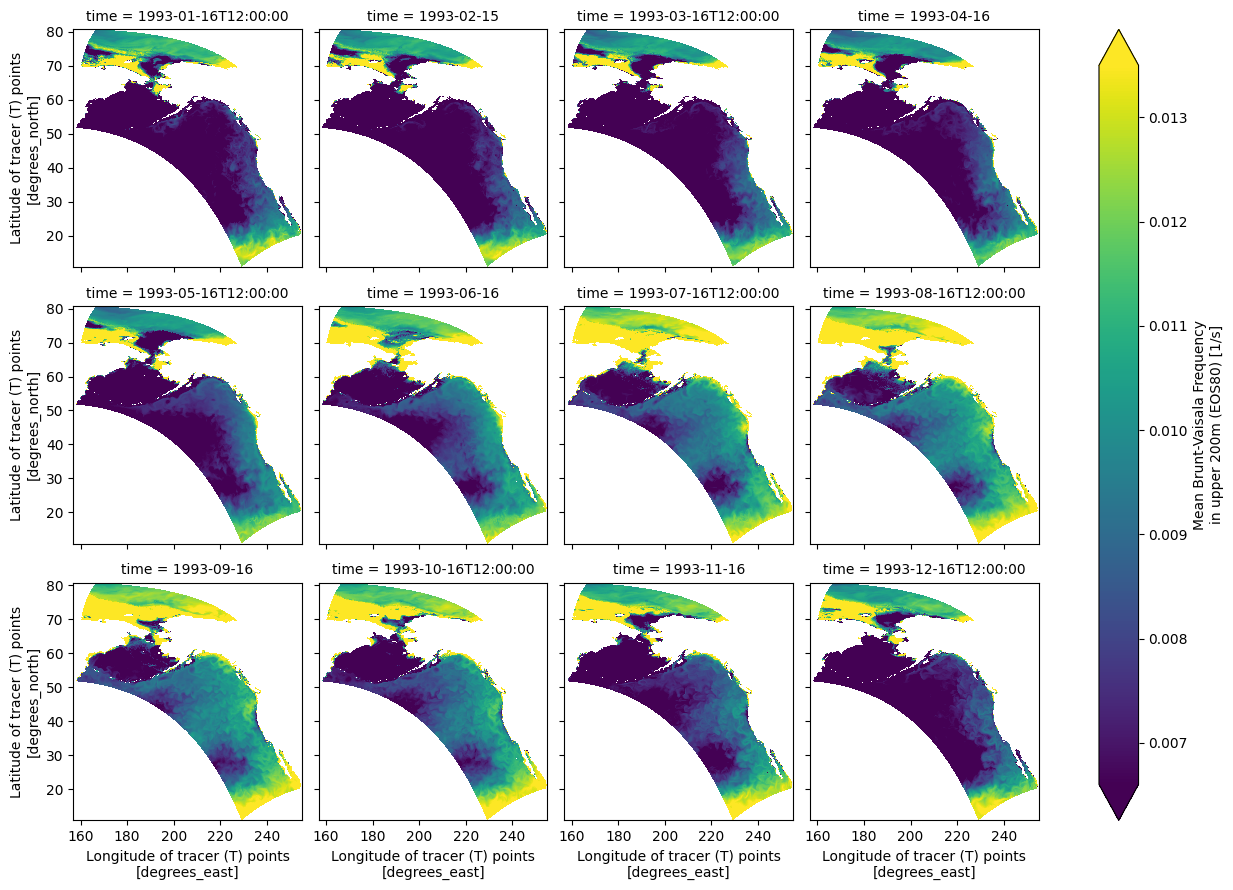

In [13]:
print("--- Calculating Brunt-Väisälä Frequency (BBV) ---")

# Apply the BBV helper function across all dimensions except 'z'
bbv_200_eos80 = xr.apply_ufunc(
    column_bbv,
    da_thetao,
    da_so,
    da_thetao['z_l'],
    da_geolon,
    da_geolat,
    kwargs={
        'eos_version': 'eos-80',
        'interp_method': 'cubic'
    },
    input_core_dims=[['z_l'], ['z_l'], ['z_l'], [], []],
    output_core_dims=[[]],
    exclude_dims=set(('z_l',)),
    vectorize=True,
    dask="parallelized",
    output_dtypes=[float]
)

# more worker less threads due to GIL of the task involved
da_bbv_200_eos80 = bbv_200_eos80.compute()

ds_bbv_200_eos80 = xr.Dataset()
ds_bbv_200_eos80['bbv_200'] = da_bbv_200_eos80
ds_bbv_200_eos80 = xr.merge([ds_bbv_200_eos80, xr.open_dataset(static_path)])
ds_bbv_200_eos80 = ds_bbv_200_eos80.set_coords(['geolon', 'geolat'])
# due to missing value in the coordinate
ds_bbv_200_eos80['geolon'] = ds_bbv_200_eos80['geolon'].where(ds_bbv_200_eos80['geolon'].notnull(), ds_bbv_200_eos80['geolon'].min())
ds_bbv_200_eos80['geolat'] = ds_bbv_200_eos80['geolat'].where(ds_bbv_200_eos80['geolat'].notnull(), ds_bbv_200_eos80['geolat'].min())

ds_bbv_200_eos80['bbv_200'].attrs['units'] = '1/s'
ds_bbv_200_eos80['bbv_200'].attrs['long_name'] = 'Mean Brunt-Vaisala Frequency in upper 200m (EOS80)'
ds_bbv_200_eos80['bbv_200'].attrs['standard_name'] = 'mean_brunt_vaisala_frequency_200m'

ds_bbv_200_eos80['bbv_200'].plot(x='geolon',y='geolat',vmin=0.0066,vmax=0.0135,col='time',col_wrap=4, cmap='viridis')

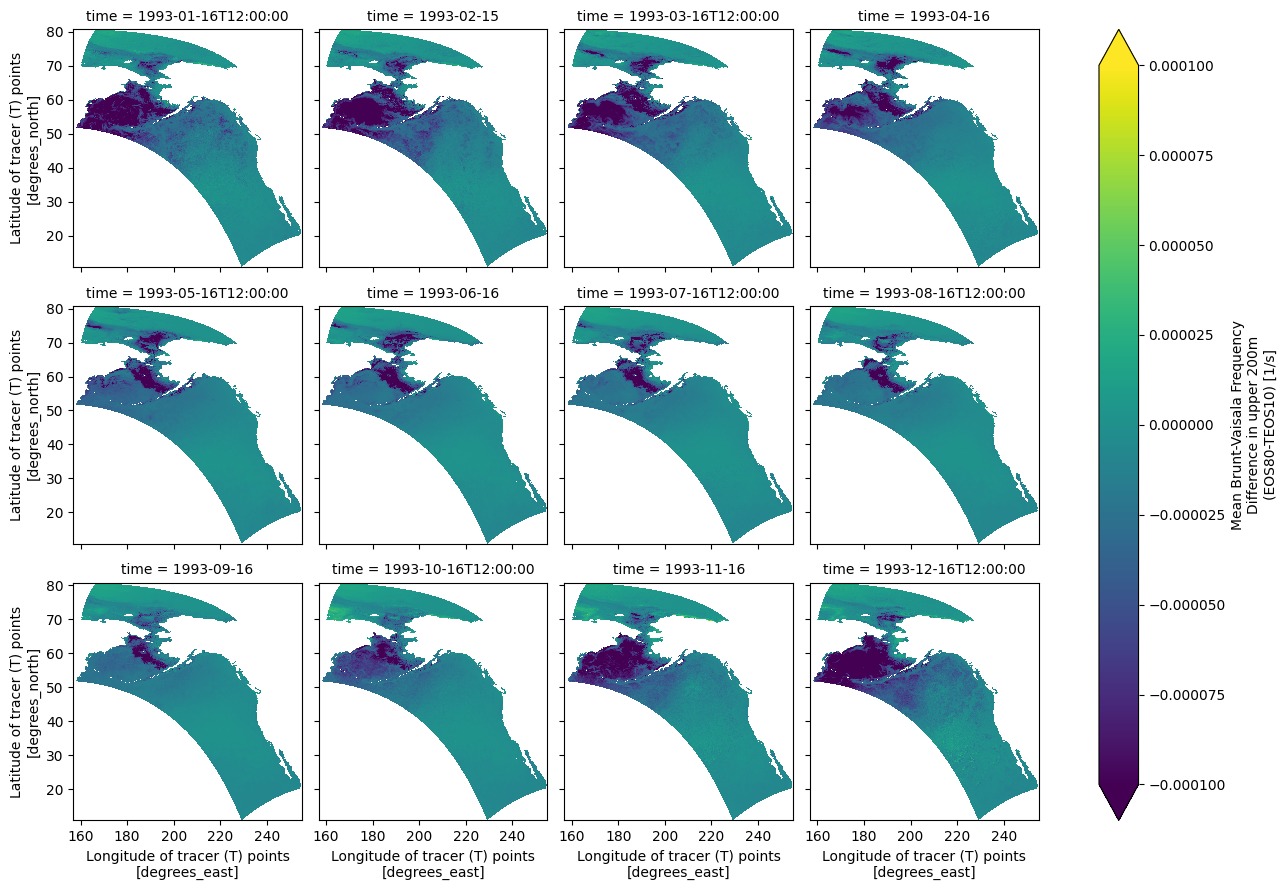

In [17]:
da_bbv_200_diff = ds_bbv_200_eos80['bbv_200']-ds_bbv_200['bbv_200']
# rename the dataset
ds_bbv_200_diff = xr.Dataset()
ds_bbv_200_diff['bbv_200_diff'] = da_bbv_200_diff
ds_bbv_200_diff['bbv_200_diff'].attrs['units'] = '1/s'
ds_bbv_200_diff['bbv_200_diff'].attrs['long_name'] = 'Mean Brunt-Vaisala Frequency Difference in upper 200m (EOS80-TEOS10)'
ds_bbv_200_diff['bbv_200_diff'].attrs['standard_name'] = 'mean_brunt_vaisala_frequency_200m_diff'

ds_bbv_200_diff['bbv_200_diff'].plot(x='geolon',y='geolat',vmin=-0.0001,vmax=0.0001,col='time',col_wrap=4, cmap='viridis')

In [26]:
xh = 100
yh = 200
salt_col = da_so.isel(xh=xh,yh=yh,time=0).values
temp_col = da_thetao.isel(xh=xh,yh=yh,time=0).values
z_col = da_thetao['z_l'].values
lon = da_geolon.isel(xh=xh,yh=yh).values
lat = da_geolat.isel(xh=xh,yh=yh).values

dens_col_eos80 = sw_dens(salt_col, temp_col)
dens_col_teos10 = teos10_sigma0(salt_col, temp_col, z_col, lon ,lat)

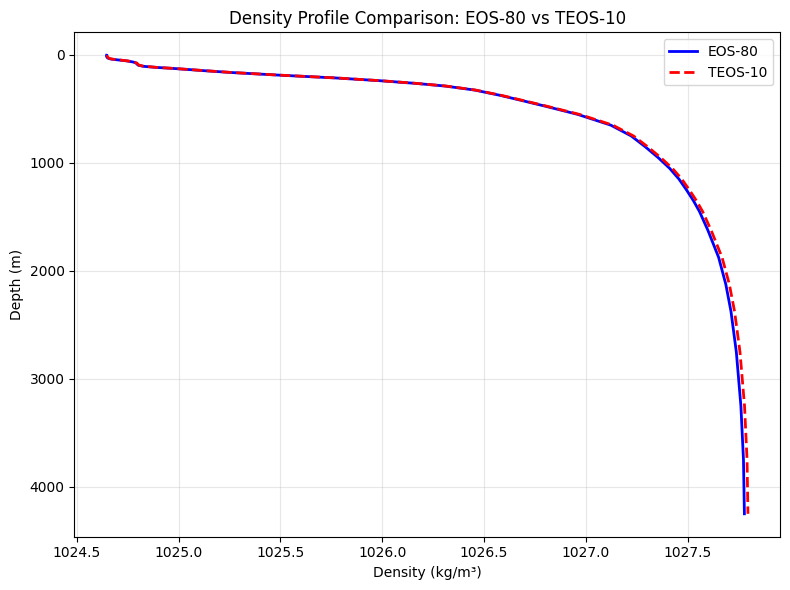

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(dens_col_eos80, z_col, 'b-', label='EOS-80', linewidth=2)
plt.plot(dens_col_teos10, z_col, 'r--', label='TEOS-10', linewidth=2)
plt.xlabel('Density (kg/m³)')
plt.ylabel('Depth (m)')
plt.gca().invert_yaxis()  # Invert y-axis so depth increases downward
plt.legend()
plt.grid(True, alpha=0.3)
plt.title('Density Profile Comparison: EOS-80 vs TEOS-10')
plt.tight_layout()
plt.show()

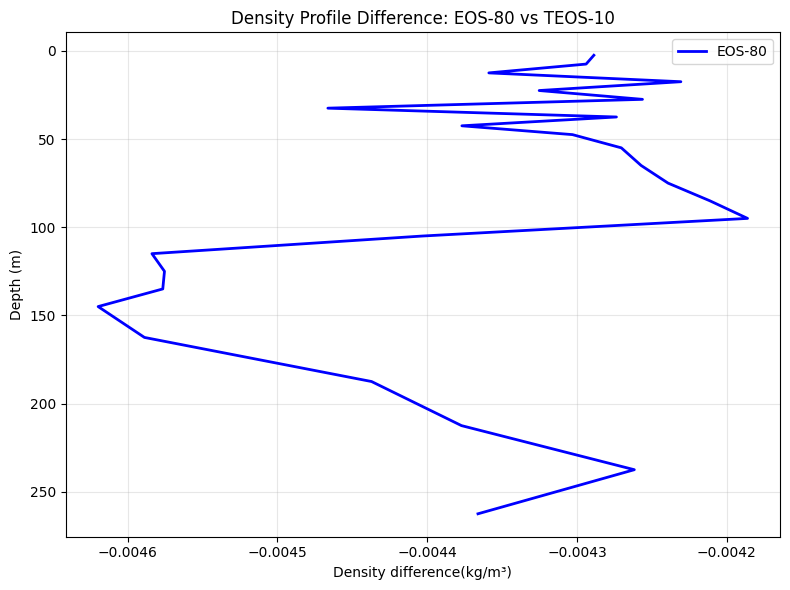

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot((dens_col_eos80-dens_col_teos10)[:25], z_col[:25], 'b-', label='EOS-80', linewidth=2)
plt.xlabel('Density difference(kg/m³)')
plt.ylabel('Depth (m)')
plt.gca().invert_yaxis()  # Invert y-axis so depth increases downward
plt.legend()
plt.grid(True, alpha=0.3)
plt.title('Density Profile Difference: EOS-80 vs TEOS-10')
plt.tight_layout()
plt.show()

# Test the above function in module

In [ ]:
from mom6.mom6_module.mom6_bbv import BruntVaisalaFrequency


In [2]:
dict_data_info = {
    "region": "northeast_pacific",
    "subdomain": "full_domain",
    "experiment_type": "hindcast",
    "output_frequency": "monthly",
    "grid_type": "raw",
    "release": "r20250509",
    "data_source": "local",
    "local_top_dir": "/Projects/CEFI/regional_mom6/"
}
from mom6.mom6_module.mom6_read import AccessFiles
cefi_data_access = AccessFiles(**dict_data_info)

In [3]:
so_path = cefi_data_access.get(variable='so')[0]
thetao_path = cefi_data_access.get(variable='thetao')[0]
static_path = cefi_data_access.get(variable='ocean_static')[0]


In [4]:
import xarray as xr
da_so = xr.open_dataset(so_path,chunks={'time': 1, 'yh': 50, 'xh': 50, 'z_l': -1})['so'].isel(time=slice(0,12))
da_thetao = xr.open_dataset(thetao_path,chunks={'time': 1, 'yh': 50, 'xh': 50, 'z_l': -1})['thetao'].isel(time=slice(0,12))
da_geolon = xr.open_dataset(static_path,chunks={'yh': 50, 'xh': 50})['geolon']
da_geolat = xr.open_dataset(static_path,chunks={'yh': 50, 'xh': 50})['geolat']

In [5]:
# more worker less threads due to GIL of the task involved
from dask.distributed import Client
client = Client(n_workers=80, threads_per_worker=1)
print(client.dashboard_link)
bbv_obj = BruntVaisalaFrequency(
    da_thetao=da_thetao,
    da_so=da_so,
    da_depth=da_thetao['z_l'],
    da_lon=da_geolon,
    da_lat=da_geolat,
    eos_version='teos-10',
    interp_method='cubic',
    depth_dim_name='z_l'
)

http://127.0.0.1:8787/status


In [6]:
ds_bbv = bbv_obj.calculate_bbv()

--- Calculating Brunt-Väisälä Frequency (BBV) ---


In [7]:
ds_bbv = ds_bbv.compute()

In [9]:
ds_bbv = xr.merge([ds_bbv, xr.open_dataset(static_path)])
ds_bbv = ds_bbv.set_coords(['geolon', 'geolat'])
# due to missing value in the coordinate
ds_bbv['geolon'] = ds_bbv['geolon'].where(ds_bbv['geolon'].notnull(), ds_bbv['geolon'].min())
ds_bbv['geolat'] = ds_bbv['geolat'].where(ds_bbv['geolat'].notnull(), ds_bbv['geolat'].min())

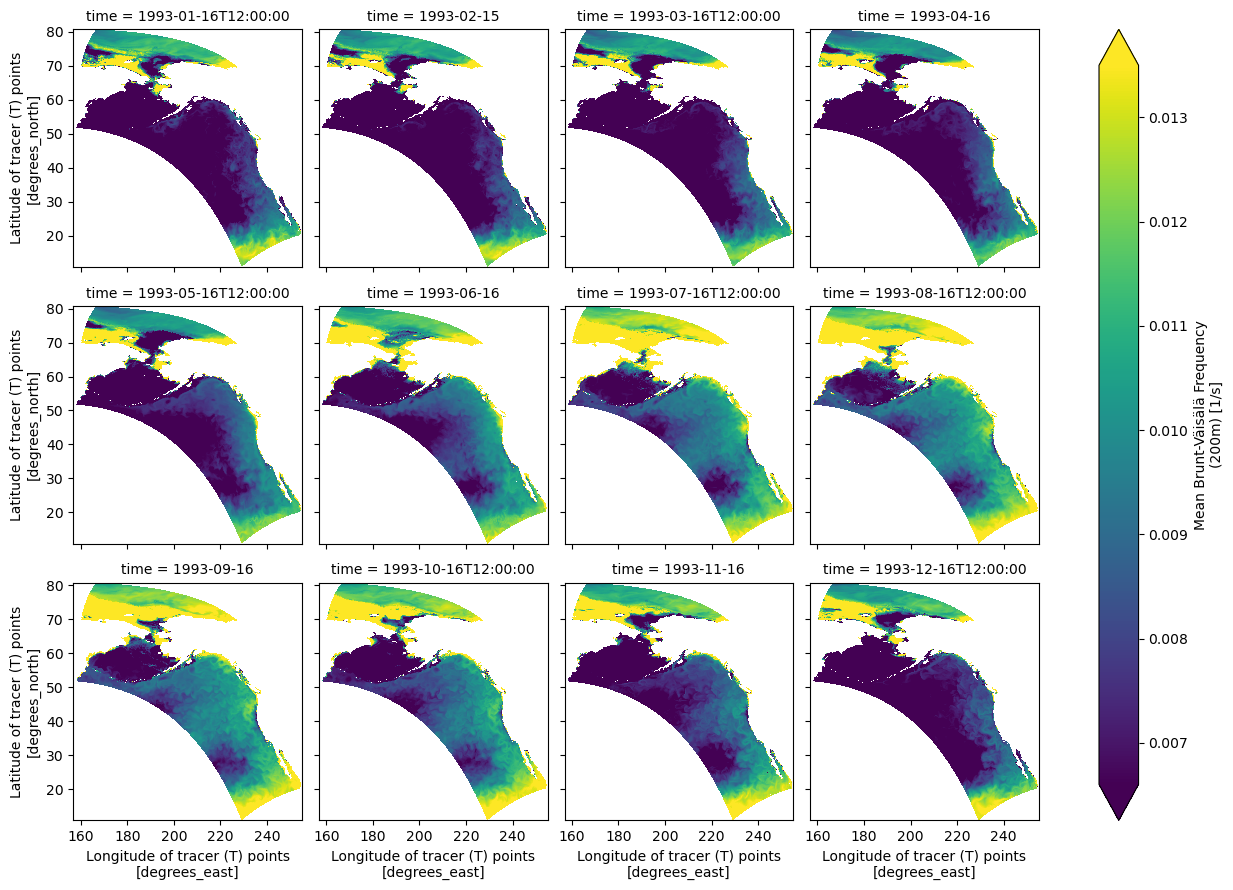

In [10]:
ds_bbv['bbv'].plot(x='geolon',y='geolat',vmin=0.0066,vmax=0.0135,col='time',col_wrap=4, cmap='viridis')